This is from Leanne Guy's DP0.1 tutorial. 
In PolyFit2 I got multidimensional features working with polynomial fits.
Now I'm trying to scale the data properly, and then make a pipeline for all of it.

In [1]:
# Import general python packages
import numpy as np
import pandas as pd

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline
# %matplotlib ipympl # currently slow, but may be a good option in the future
import matplotlib.pyplot as plt

# Set the maximum number of rows to display from pandas
pd.set_option('display.max_rows', 20)

In [2]:
# Ignore warnings when uncommented
# from astropy.units import UnitsWarning
# warnings.simplefilter("ignore", category=UnitsWarning)

In [3]:
# Get an instance of the TAP service
service = get_tap_service()
assert service is not None
# assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [4]:
# Define a reference position on the sky and cone radius in arcseconds
coord = SkyCoord(ra=62.0*u.degree, dec=-37.0*u.degree, frame='icrs')
radius = 0.1 * u.deg

In [5]:
# Try looking at galaxies first
# You'll want to add detect_isPrimary = True when you shift to DP0.2
query = "SELECT obj.objectId, obj.ra, obj.dec, obj.mag_u, obj.mag_g, " \
        " obj.mag_r, obj.mag_i, obj.mag_z, obj.mag_y, obj.psFlux_u, " \
        "obj.psFlux_g, obj.psFlux_r, obj.psFlux_i, obj.psFlux_z, " \
        "obj.psFlux_y, obj.tract, obj.patch, " \
        "truth.mag_r as truth_mag_r, "\
        "truth.flux_u, truth.flux_g, truth.flux_r, truth.flux_i, " \
        "truth.flux_z, truth.flux_y, truth.redshift " \
        "FROM dp01_dc2_catalogs.object as obj " \
        "JOIN dp01_dc2_catalogs.truth_match as truth " \
        "ON truth.match_objectId = obj.objectId " \
        "WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', " \
        + str(coord.ra.value) + ", " + str(coord.dec.value) + ", " \
        + str(radius.value) + " )) = 1 " \
        "AND truth.match_objectid >= 0 " \
        "AND truth.is_good_match = 1" \
        "AND obj.clean = 1 AND obj.good = 1" \
        "AND obj.extendedness = 1"
print(query)

SELECT obj.objectId, obj.ra, obj.dec, obj.mag_u, obj.mag_g,  obj.mag_r, obj.mag_i, obj.mag_z, obj.mag_y, obj.psFlux_u, obj.psFlux_g, obj.psFlux_r, obj.psFlux_i, obj.psFlux_z, obj.psFlux_y, obj.tract, obj.patch, truth.mag_r as truth_mag_r, truth.flux_u, truth.flux_g, truth.flux_r, truth.flux_i, truth.flux_z, truth.flux_y, truth.redshift FROM dp01_dc2_catalogs.object as obj JOIN dp01_dc2_catalogs.truth_match as truth ON truth.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', 62.0, -37.0, 0.1 )) = 1 AND truth.match_objectid >= 0 AND truth.is_good_match = 1AND obj.clean = 1 AND obj.good = 1AND obj.extendedness = 1


In [6]:
# For more detailed analysis of results, converting
# to a pandas dataframe is often very useful ("df" stands for "dataframe")
df = service.search(query).to_table().to_pandas()

# Use an assertion to make sure we got the correct number of results.
# assert len(df) == 15670
len(df.ra)

10957

In [7]:
# Get rid of all rows that contain NaN values.
# Thre are aother fixes for this, like imputation.
df2 = df.dropna(axis=0)

In [8]:
len(df2)

8139

In [9]:
ugcolor = df2['mag_u'] - df2['mag_g']
grcolor = df2['mag_g'] - df2['mag_r']
ricolor = df2['mag_r'] - df2['mag_i']
izcolor = df2['mag_i'] - df2['mag_z']
zycolor = df2['mag_z'] - df2['mag_y']
df2['ugcolor'] = ugcolor
df2['grcolor'] = grcolor
df2['ricolor'] = ricolor
df2['izcolor'] = izcolor
df2['zycolor'] = zycolor

/tmp/ipykernel_1714/1239832705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ugcolor'] = ugcolor
/tmp/ipykernel_1714/1239832705.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['grcolor'] = grcolor
/tmp/ipykernel_1714/1239832705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [10]:
# Reposition redshift column to first column
first_column = df2.pop('redshift')
df2.insert(0, 'redshift', first_column)
df2.columns

Index(['redshift', 'objectId', 'ra', 'dec', 'mag_u', 'mag_g', 'mag_r', 'mag_i',
       'mag_z', 'mag_y', 'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i',
       'psFlux_z', 'psFlux_y', 'tract', 'patch', 'truth_mag_r', 'flux_u',
       'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y', 'ugcolor', 'grcolor',
       'ricolor', 'izcolor', 'zycolor'],
      dtype='object')

In [11]:
# Look for correlations between features and the target
# df2.corr()
feature_names = ["grcolor", "ricolor", "mag_i", "mag_r", "mag_z", "mag_y"]
for feature in feature_names:
    print(df2.redshift.corr(df2[feature]))


-0.4957441205727808
-0.35614285276414054
0.44712862483707916
0.34030639375985794
0.4039119412371572
0.3840632665667721


Text(0, 0.5, 'redshift')

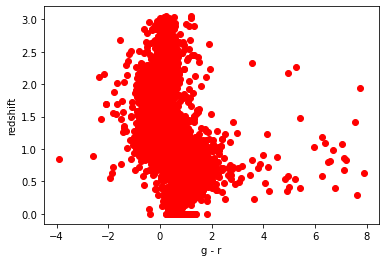

In [12]:
# Plot some variables get a better idea of the data
# For example, it might be a good idea to re-scale the data.
plt.scatter(df2.grcolor, df2.redshift, color = 'red')
plt.xlabel('g - r')
plt.ylabel('redshift')
# plt.gca().invert_xaxis()

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [59]:
from sklearn.pipeline import make_pipeline
# pipe = make_pipeline(MaxAbsScaler(), PolynomialFeatures(degree=3, include_bias=False),
#                      LinearRegression())
# pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=3, include_bias=False),
#                      LinearRegression())
# pipe = make_pipeline(RobustScaler(), PolynomialFeatures(degree=3, include_bias=False),
#                      LinearRegression())
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3, include_bias=False),
                     LinearRegression())

In [60]:
# scaler = StandardScaler()
X, y = df2[["grcolor", "mag_i", "mag_r", "mag_z", "mag_y", "ricolor"]], df2["redshift"]
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y.values.reshape(-1,1))


In [61]:
# poly = PolynomialFeatures(degree=3, include_bias=False)
# poly_features = poly.fit_transform(X_scaled)
# X_train, X_test, y_train, y_test = train_test_split(poly_features, y, 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=42)

In [63]:
# poly_reg_model = LinearRegression()
# poly_reg_model.fit(X_train, y_train)
poly_reg_model = pipe.fit(X_train, y_train)

In [64]:
poly_reg_y_predicted = poly_reg_model.predict(X_test)
from sklearn.metrics import mean_squared_error
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
poly_reg_rmse

0.4134360045280531

In [65]:
len(X_train['mag_r'])

5697

Text(0, 0.5, 'poly_reg_y_predicted')

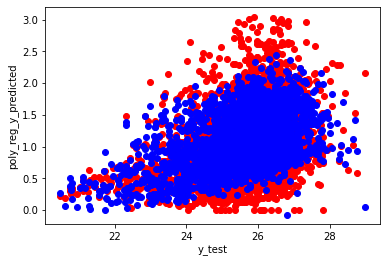

In [66]:
plt.scatter(X_test['mag_r'], y_test, label='y_test', color = 'red')
plt.scatter(X_test['mag_r'], poly_reg_y_predicted, label='y_predicted', color = 'blue')
plt.xlabel('y_test')
plt.ylabel('poly_reg_y_predicted')
# plt.xlim(0., 2.5)
# plt.ylim(0., 2.5)

In [56]:
poly_reg_model.get_params()

{'memory': None,
 'steps': [('maxabsscaler', MaxAbsScaler()),
  ('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=False)),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'maxabsscaler': MaxAbsScaler(),
 'polynomialfeatures': PolynomialFeatures(degree=3, include_bias=False),
 'linearregression': LinearRegression(),
 'maxabsscaler__copy': True,
 'polynomialfeatures__degree': 3,
 'polynomialfeatures__include_bias': False,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': 'deprecated',
 'linearregression__positive': False}

In [57]:
poly_reg_model.score(X_test, y_test)

0.5199875449456552